# Phylogenetic signals

Test east branch of the plant phylogeny against wide groups

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
library(Hmisc)
library(lme4)
library(lmerTest)
library(ggplot2)
library(dplyr)
library(tidyr)
library(pbkrtest)
library(grid)
library(gridExtra)
library(reshape2)
library(picante)
library(ape)
library(DESeq2)
library(phyloseq)
library(doParallel)
library(foreach)
library(doParallel)


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: lattice

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: survival

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: Formula

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: ggplot2

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘Hmisc’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: 

# Load phyloseq object and trim to responders

In [4]:
%%R
log2foldFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/DeSeq2/bare-plant.csv'
F = file.path('/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/physeq/Full-Sparsity3in3')
 
#rarified file for relative abundance estimates

physeq.Full = readRDS(F)

# read rhizosphere log2fold change file and 
l2f = read.csv(log2foldFile, header = TRUE) 
l2f = l2f[l2f$p.adj < .05,]
resp = l2f$OTU %>% unique %>% as.character
l2f = NULL

phy = filter_taxa(physeq.Full, function(x) sum(x > 0) > 0, TRUE)
phy = prune_taxa(resp, phy)
phy = subset_samples(phy, Plant != "BARE")
phy %>% print
    

#read in relative abundance
Fr = file.path('/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/physeq/Full-Sparsity3in3_relabund')
phy_r = readRDS(Fr)
phy_r = prune_taxa(resp, phy_r)
phy_r = subset_samples(phy_r, Plant != "BARE") 
phy_r

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1506 taxa and 174 samples ]
sample_data() Sample Data:       [ 174 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 1506 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1506 tips and 1505 internal nodes ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1506 taxa and 174 samples ]
sample_data() Sample Data:       [ 174 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 1506 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1506 tips and 1505 internal nodes ]


# Maize vs other

In [5]:
%%R
sample_data(phy)$Contrast = ifelse(sample_data(phy)$Type == "Maize", "Maize", "Non_Maize") %>% as.factor

In [13]:
%%R
sample_data(phy)$Library = as.factor(sample_data(phy)$Library)
sample_data(phy)$Contrast = relevel(sample_data(phy)$Contrast, "Non_Maize")
dds = phyloseq_to_deseq2(phy, ~Contrast)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print
DF = results(d_dds)

supp = tax_table(phy)
            if (!setequal(row.names(supp), row.names(DF))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)
        DF$Test = "Maize"

[1] "Intercept"         "ContrastNon_Maize" "ContrastMaize"    


In [16]:
%%R
temp = merge_samples(phy, "Contrast")

temp = transform_sample_counts(temp, function(x) x/sum(x))
sample_names(temp)

#Melt to bring into long data format   
temp = temp %>% otu_table %>% as.data.frame 
temp$Contrast = rownames(temp)
    

temp = temp["Maize",]
OTUrel = melt(temp, id = "Contrast")

colnames(OTUrel)[2:3] = c("OTU", "RelAbund")
    
# Join l2f and relabund data
DF = left_join(DF, OTUrel)
    
#Clean up
temp = NULL
OTUrel = NULL 

MCmaize = DF
head(MCmaize)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Joining, by = "OTU"

  res = super(Function, self).__call__(*new_args, **new_kwargs)


    baseMean log2FoldChange     lfcSE          stat       pvalue        padj
1  0.1669131   0.9341849010 0.6861643  1.3614594753 0.1733685318 0.297044581
2  0.6311662   1.3533367388 0.3723908  3.6341838849 0.0002788619 0.001833913
3  1.9873323  -0.2593614348 0.2706771 -0.9581949320 0.3379644723 0.479712060
4  0.5950191   0.0002442723 0.3377740  0.0007231827 0.9994229837 0.999422984
5  0.8520297   0.0566378903 0.3149033  0.1798580480 0.8572640109 0.915630922
6 28.6100613  -0.3534431194 0.1025579 -3.4462775828 0.0005683662 0.003330582
     Rank1         Rank2                Rank3                Rank4 Rank5 Rank6
1 Bacteria           TM6 uncultured_bacterium                 <NA>  <NA>  <NA>
2 Bacteria           TM6 uncultured_bacterium                 <NA>  <NA>  <NA>
3 Bacteria Elusimicrobia          Lineage_IIb uncultured_bacterium  <NA>  <NA>
4 Bacteria Elusimicrobia          Lineage_IIb uncultured_bacterium  <NA>  <NA>
5 Bacteria Elusimicrobia               MVP-88 uncultured_bacterium

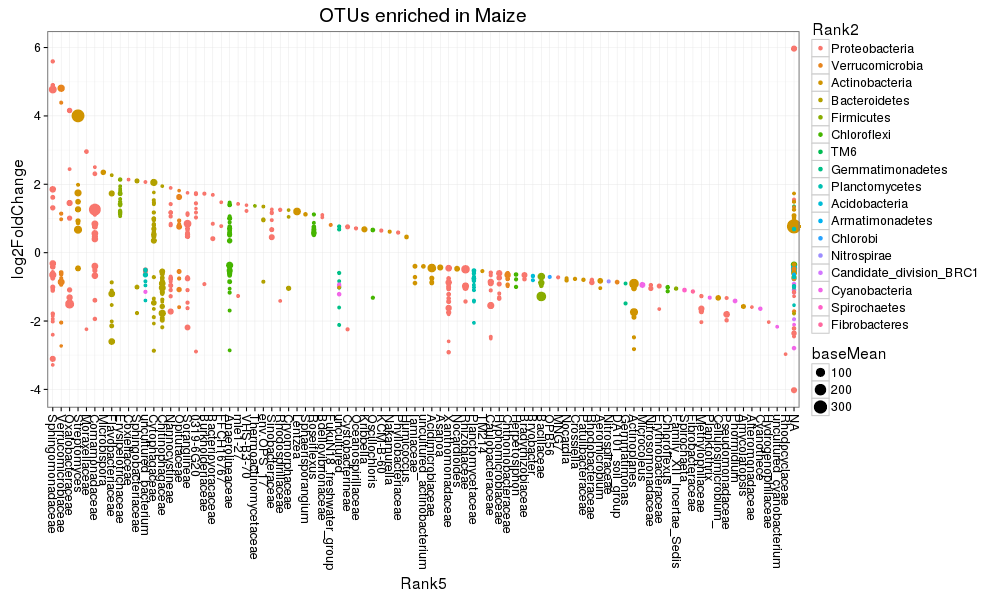

In [17]:
%%R -w 1000 -h 600
sigtab = filter(MCmaize, padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))
x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))
    
ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2, size = baseMean)) + 
    geom_point() +
    theme_bw(base_size = 16) +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5)) +
    ggtitle("OTUs enriched in Maize")

# Andropogoneae vs other w/ only one maize from each sampling date 

In [18]:
%%R
phy.p = subset_samples(phy, Type != "Maize" | Plant == "B73" | Plant == "Mo18" | Plant == "MS71")


In [19]:
%%R
sample_data(phy.p)$Contrast = ifelse(sample_data(phy.p)$Plant %in% c("B73", "Mo18", "MS71", "SORSUD",
                                                    "SORBI"), "Andropogoneae", "Other") %>% as.factor()
sample_data(phy.p)[,c("Plant", "Contrast")] %>% str()
sample_data(phy.p)$Contrast = relevel(sample_data(phy.p)$Contrast, "Other")

'data.frame':	110 obs. of  2 variables:
Formal class 'sample_data' [package "phyloseq"] with 4 slots
  ..@ .Data    :List of 2
  .. ..$ : Factor w/ 14 levels "ABUTH","AMAPO",..: 12 11 11 6 12 12 11 7 3 3 ...
  .. ..$ : Factor w/ 2 levels "Andropogoneae",..: 2 1 1 2 2 2 1 2 1 1 ...
  ..@ names    : chr  "Plant" "Contrast"
  ..@ row.names: chr  "sample4-1.03_Npos" "sample5-2.06_Npos" "sample5-4.08_Npos" "sample5-1.29_Npos" ...
  ..@ .S3Class : chr "data.frame"


In [20]:
%%R
sample_data(phy.p)$Library = as.factor(sample_data(phy.p)$Library)
sample_data(phy.p)$Contrast = relevel(sample_data(phy.p)$Contrast, "Other")
dds = phyloseq_to_deseq2(phy.p, ~Contrast)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print
DF = results(d_dds)

supp = tax_table(phy.p)
            if (!setequal(row.names(supp), row.names(DF))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)
        DF$Test = "Andropogoneae"

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: -- replacing outliers and refitting for 114 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[1] "Intercept"             "ContrastOther"         "ContrastAndropogoneae"


In [21]:
%%R
temp = merge_samples(phy.p, "Contrast")

temp = transform_sample_counts(temp, function(x) x/sum(x))
sample_names(temp) %>% print

#Melt to bring into long data format   
temp = temp %>% otu_table %>% as.data.frame 
temp$Contrast = rownames(temp)
temp = temp["Andropogoneae",]
OTUrel = melt(temp, id = "Contrast")

colnames(OTUrel)[2:3] = c("OTU", "RelAbund")
    
# Join l2f and relabund data
DF = left_join(DF, OTUrel)
    
#Clean up
temp = NULL
OTUrel = NULL 

MCandro = DF
head(MCandro)

[1] "Other"         "Andropogoneae"
     baseMean log2FoldChange     lfcSE       stat      pvalue       padj
1  0.05507053     -0.2104560 0.9436845 -0.2230152 0.823523655 0.88587616
2  0.46264780      1.3205452 0.4800033  2.7511171 0.005939241 0.02058279
3  1.74534532     -0.8803579 0.3877356 -2.2705111 0.023176591 0.05910074
4  0.48875497     -0.6455261 0.5161421 -1.2506750 0.211053060 0.33492720
5  0.76883510     -0.1296323 0.4327176 -0.2995772 0.764499701 0.84347000
6 27.04851516      0.1783664 0.1443795  1.2353997 0.216681770 0.34277599
     Rank1         Rank2                Rank3                Rank4 Rank5 Rank6
1 Bacteria           TM6 uncultured_bacterium                 <NA>  <NA>  <NA>
2 Bacteria           TM6 uncultured_bacterium                 <NA>  <NA>  <NA>
3 Bacteria Elusimicrobia          Lineage_IIb uncultured_bacterium  <NA>  <NA>
4 Bacteria Elusimicrobia          Lineage_IIb uncultured_bacterium  <NA>  <NA>
5 Bacteria Elusimicrobia               MVP-88 uncultured_b

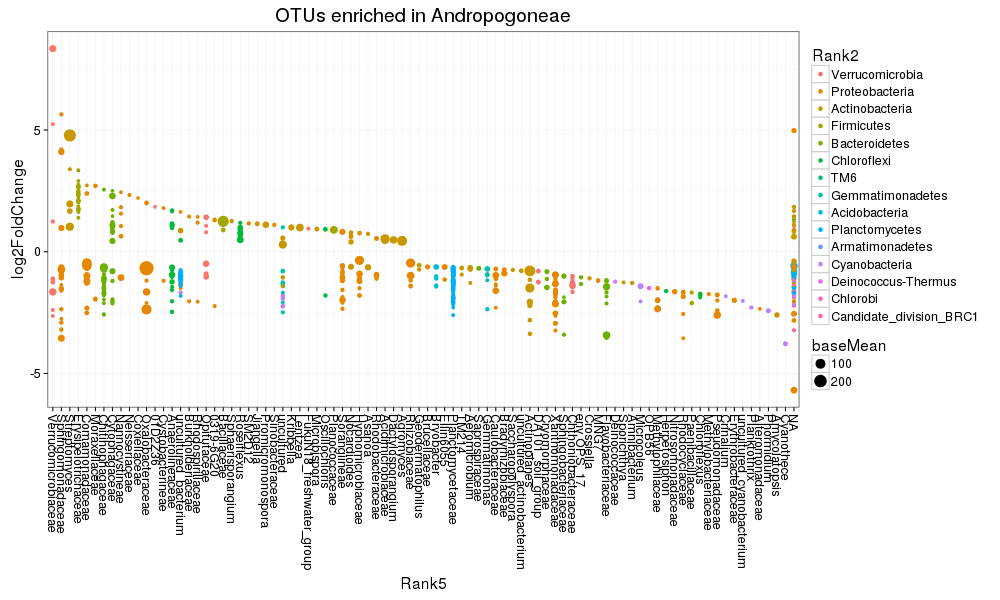

In [22]:
%%R -w 1000 -h 600
sigtab = filter(MCandro, padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))
x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))
    
ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2, size = baseMean)) + 
    geom_point() +
    theme_bw(base_size = 16) +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5)) +
    ggtitle("OTUs enriched in Andropogoneae")
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x

# Chloridoideae

In [24]:
%%R
phy.p = subset_samples(phy, Type != "Maize" | Plant == "B73")

# add family and subfamily
sample_data(phy.p)$Contrast = ifelse(sample_data(phy.p)$Plant %in% c("ELCOR", "ERATE"), "Chloridoideae", "Other") %>%
    as.factor()
sample_data(phy.p)$Contrast = relevel(sample_data(phy.p)$Contrast, "Other")

str(sample_data(phy.p)$Contrast)


 Factor w/ 2 levels "Other","Chloridoideae": 1 2 1 1 1 1 1 1 1 1 ...


In [25]:
%%R
sample_data(phy.p)$Library = as.factor(sample_data(phy.p)$Library)
dds = phyloseq_to_deseq2(phy.p, ~Contrast)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print
DF = results(d_dds)

supp = tax_table(phy.p)
            if (!setequal(row.names(supp), row.names(DF))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)
        DF$Test = "Chloridoideae"

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: -- replacing outliers and refitting for 115 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[1] "Intercept"             "ContrastOther"         "ContrastChloridoideae"


In [26]:
%%R
temp = merge_samples(phy.p, "Contrast")

temp = transform_sample_counts(temp, function(x) x/sum(x))
sample_names(temp) %>% print

#Melt to bring into long data format   
temp = temp %>% otu_table %>% as.data.frame 
temp$Contrast = rownames(temp)
temp = temp["Chloridoideae",]
OTUrel = melt(temp, id = "Contrast")

colnames(OTUrel)[2:3] = c("OTU", "RelAbund")
    
# Join l2f and relabund data
DF = left_join(DF, OTUrel)
    
#Clean up
temp = NULL
OTUrel = NULL 

MCchlor = DF
head(MCchlor)

[1] "Other"         "Chloridoideae"
     baseMean log2FoldChange     lfcSE       stat       pvalue         padj
1  0.05961168     -0.4764771 1.0428823 -0.4568848 6.477539e-01           NA
2  0.40546689      0.6155866 0.7669312  0.8026621 4.221701e-01 6.237468e-01
3  1.69270247      0.3855738 0.5504445  0.7004772 4.836293e-01 6.747040e-01
4  0.47341904      0.4906365 0.6963441  0.7045891 4.810660e-01 6.725471e-01
5  0.71312897      2.3131447 0.4667886  4.9554437 7.216541e-07 3.132828e-05
6 26.23215590     -0.7954156 0.2110789 -3.7683326 1.643416e-04 2.958149e-03
     Rank1         Rank2                Rank3                Rank4 Rank5 Rank6
1 Bacteria           TM6 uncultured_bacterium                 <NA>  <NA>  <NA>
2 Bacteria           TM6 uncultured_bacterium                 <NA>  <NA>  <NA>
3 Bacteria Elusimicrobia          Lineage_IIb uncultured_bacterium  <NA>  <NA>
4 Bacteria Elusimicrobia          Lineage_IIb uncultured_bacterium  <NA>  <NA>
5 Bacteria Elusimicrobia             

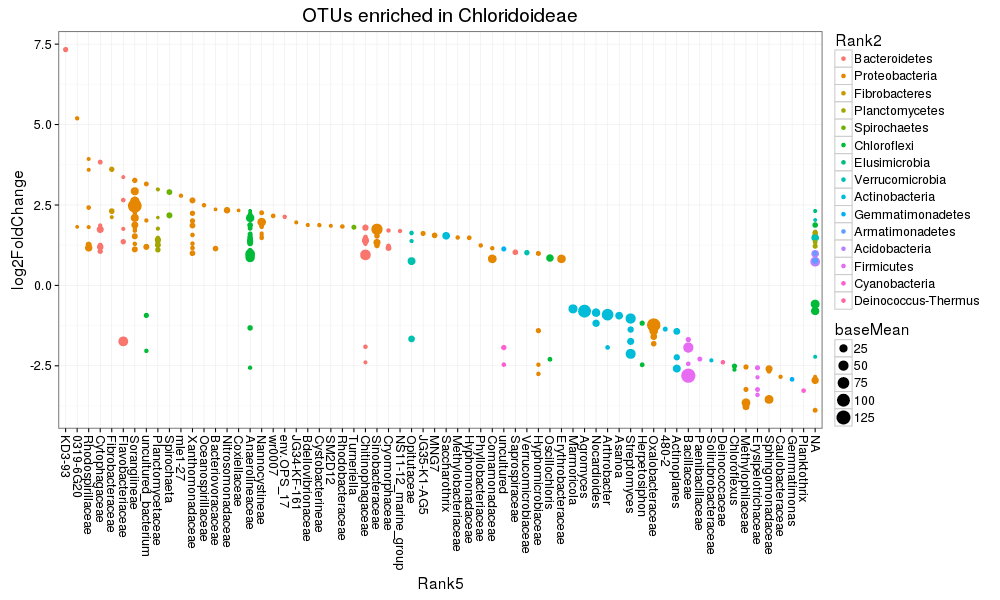

In [27]:
%%R -w 1000 -h 600
sigtab = filter(MCchlor, padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))
x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))
    
ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2, size = baseMean)) + 
    geom_point() +
    theme_bw(base_size = 16) +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5)) +
    ggtitle("OTUs enriched in Chloridoideae")
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x

# Poaceae vs dicot when only one maize is included for better balance  

In [95]:
%%R
phy.p = subset_samples(phy, Type != "Maize" | Plant == "B73") 

# add family and subfamily
sample_data(phy.p)$Contrast = ifelse(sample_data(phy.p)$Type %in% c("C4_Grass", "Maize"), "Poaceae", "Dicots") %>%
    as.factor()
sample_data(phy.p)$Contrast = relevel(sample_data(phy.p)$Contrast, "Poaceae")
str(sample_data(phy.p)$Contrast)


 Factor w/ 2 levels "Poaceae","Dicots": 1 1 1 1 2 1 1 2 2 2 ...


In [96]:
%%R
sample_data(phy.p)$Library = as.factor(sample_data(phy.p)$Library)
dds = phyloseq_to_deseq2(phy.p, ~Library + Contrast)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print
DF = results(d_dds)

supp = tax_table(phy.p)
            if (!setequal(row.names(supp), row.names(DF))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)
        DF$Test = "Dicots"

[1] "Intercept"       "Library1"        "Library2"        "ContrastPoaceae"
[5] "ContrastDicots" 


In [97]:
%%R
temp = merge_samples(phy.p, "Contrast")

temp = transform_sample_counts(temp, function(x) x/sum(x))
sample_names(temp) %>% print

#Melt to bring into long data format   
temp = temp %>% otu_table %>% as.data.frame 
temp$Contrast = rownames(temp)
temp = temp["Dicots",]
OTUrel = melt(temp, id = "Contrast")

colnames(OTUrel)[2:3] = c("OTU", "RelAbund")
    
# Join l2f and relabund data
DF = left_join(DF, OTUrel)
    
#Clean up
temp = NULL
OTUrel = NULL 

MCpoac = DF
head(MCpoac)

[1] "Poaceae" "Dicots" 
     baseMean log2FoldChange     lfcSE       stat       pvalue         padj
1  0.05961168     -0.2994456 0.9093693 -0.3292893 7.419370e-01 0.8555944061
2  0.40546689     -1.3775277 0.6197822 -2.2225995 2.624282e-02 0.0903917447
3  1.69270247      0.9005749 0.4007599  2.2471683 2.462927e-02 0.0868587765
4  0.47341904      0.2736385 0.5396016  0.5071120 6.120763e-01 0.7626178476
5  0.71312897     -2.0630516 0.5035795 -4.0967743 4.189471e-05 0.0006246874
6 26.23215590      0.4572650 0.1456779  3.1388765 1.695969e-03 0.0121625233
     Rank1         Rank2                Rank3                Rank4 Rank5 Rank6
1 Bacteria           TM6 uncultured_bacterium                 <NA>  <NA>  <NA>
2 Bacteria           TM6 uncultured_bacterium                 <NA>  <NA>  <NA>
3 Bacteria Elusimicrobia          Lineage_IIb uncultured_bacterium  <NA>  <NA>
4 Bacteria Elusimicrobia          Lineage_IIb uncultured_bacterium  <NA>  <NA>
5 Bacteria Elusimicrobia               MVP-88 unc

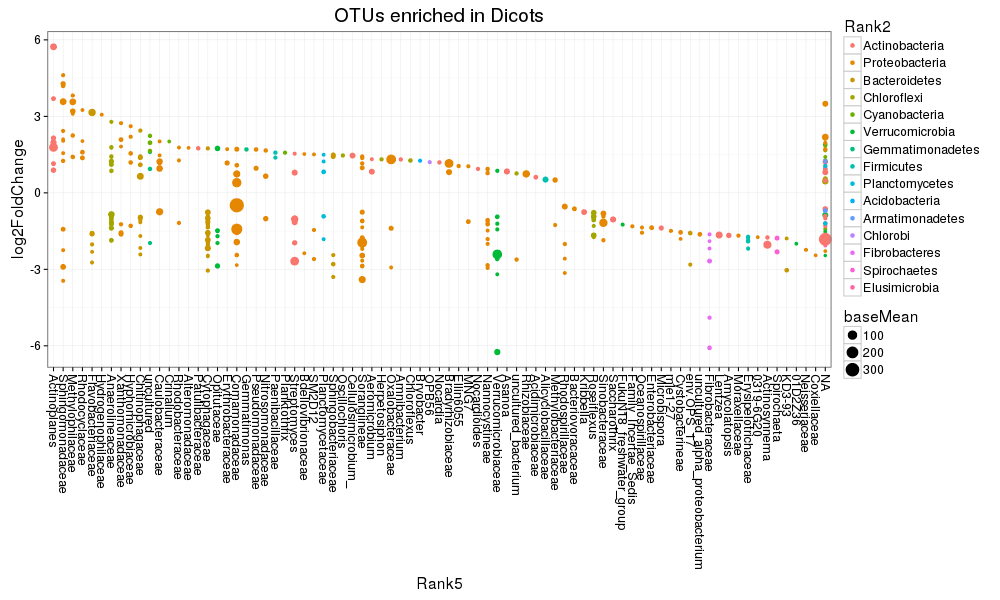

In [283]:
%%R -w 1000 -h 600
sigtab = filter(MCpoac, padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))
x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))
    
ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2, size = baseMean)) + 
    geom_point() +
    theme_bw(base_size = 16) +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5)) +
    ggtitle("OTUs enriched in Dicots")
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x


In [290]:
%%R
sigtab %>% filter(log2FoldChange < 0) %>% dim #, "OTUs with poaceae/dicot signal")

[1] 198  18


# Write file for use in heatmap notebook

In [100]:
%%R
MC = rbind(MCmaize, MCandro, MCchlor, MCpoac)
dim(MC)

[1] 6024   18


In [101]:
%%R
write.table(MC, file ='/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/DeSeq2/PhylogeneticSignal_groupvsall.txt', sep = "\t")

# Checkpoint - proceed from here for graphing

## Making tree plot & metadata plots separately, then combining with grid.arrange

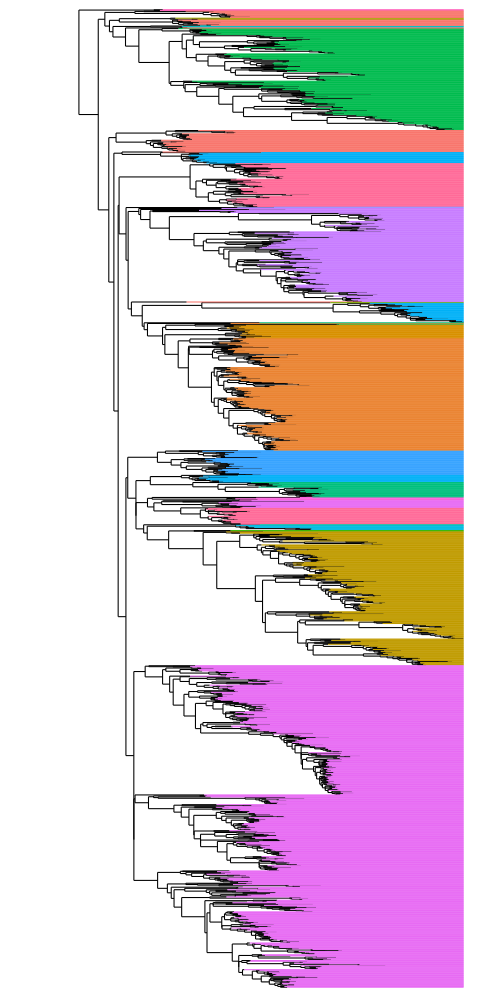

In [102]:
%%R -h 1000

plot_tree = function(physeq, color.rank="Rank2", legend.title='Phylum', 
                     plot.margin=NULL, y.expand=c(0.01,0.01),
                     legend.position='none', legend.size=4){
    # general tree plotting with ggplot
    as.Num = function(x){ x %>% as.character %>% as.numeric }
    
    # plot margin
    if(is.null(plot.margin)){
        plot.margin = unit(c(0,0,0,0), "cm")  # top, right, bottom, left        
    }

    # get tree coords
    treeSegs = phyloseq:::tree_layout(phy_tree(physeq), ladderize='right')

    # edge parsing 
    edge_inner = treeSegs$edgeDT[is.na(treeSegs$edgeDT$OTU)]
    edge_otu = treeSegs$edgeDT[! is.na(treeSegs$edgeDT$OTU)]

    # adding taxonomy to left edges
    physeq.tax = physeq %>% tax_table %>% as.matrix %>% as.data.frame %>%
        mutate(OTU = rownames(.))
    edge_otu.df = edge_otu %>% as.matrix %>% as.data.frame %>%
        mutate(xleft = xleft %>% as.Num,
               xright = xright %>% as.Num,
               y = y %>% as.Num)
    edge_otu.df = inner_join(edge_otu.df, physeq.tax, c('OTU' = 'OTU')) %>%
        mutate(Rank2 = gsub('^__', '', Rank2),
               Rank3 = gsub('^__', '', Rank3),
               Rank4 = gsub('^__', '', Rank4),
               Rank5 = gsub('^__', '', Rank5),
               Rank6 = gsub('^__', '', Rank6),
               Rank7 = gsub('^__', '', Rank7),
               Rank8 = gsub('^__', '', Rank8)) 
    
    # adding node-metadata connector lines
    edge_otu.con = edge_otu.df %>%
                     mutate(max.xright = max(xright, na.rm=T),
                            xleft = xright,
                            xright = max.xright)
    
    # dummy facet
    edge_inner$FACET = 1
    
    # making tree plot
    p.tree = ggplot(data=edge_inner) + 
        geom_segment(aes(x=xleft, xend=xright, y=y, yend=y)) + 
        geom_segment(data=edge_otu.df, 
                     aes(x=xleft, xend=xright, y=y, yend=y)) +
        geom_segment(data=edge_otu.con,
                     aes_string(x="xleft", xend="xright", y="y", 
                                yend="y", color=color.rank)) + 
        geom_segment(data=treeSegs$vertDT, 
                     aes(x=x, xend=x, y=vmin, yend=vmax)) +
        scale_y_continuous(expand=y.expand) +
        scale_color_discrete(legend.title) +
        facet_grid(. ~ FACET) +
        theme_bw() +
        guides(colour = guide_legend(override.aes = list(size=legend.size))) +
        theme(
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            panel.border = element_blank(),
            panel.background = element_blank(),
            axis.title = element_blank(),
            axis.text = element_blank(),
            axis.ticks = element_blank(),
            legend.position = legend.position,
            legend.background = element_blank(),
            legend.key = element_blank(),
            strip.background = element_blank(),
            strip.text = element_blank(),
            plot.margin = plot.margin
            )
    return(p.tree)
    }

#-- test --#
p.tree = plot_tree(phy, 
          legend.title='Phylum', 
          legend.position='none', 
          plot.margin=unit(c(0,-0.1,0,2),'cm'))
p.tree

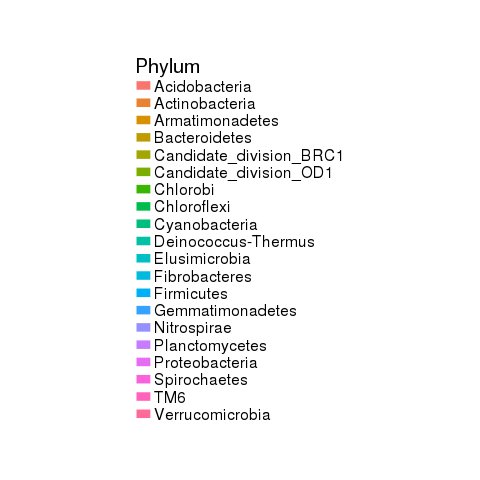

In [103]:
%%R

g_legend = function(a.gplot, text.size = 20, legend.position=c(0.5, 0.5)){ 
    # function for plotting just legend
    a.gplot = a.gplot + theme(legend.position=legend.position, 
                              text = element_text(size=text.size))
    tmp = ggplot_gtable(ggplot_build(a.gplot)) 
    leg = which(sapply(tmp$grobs, function(x) x$name) == "guide-box") 
    legend = tmp$grobs[[leg]] 
    return(legend)
    } 
                        
my.legend = g_legend(p.tree)
grid.draw(my.legend)

## Prepare metadata

In [125]:
%%R
#Read in responder tables
setwd("/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/DeSeq2/")

l2fc = read.delim(file = 'PhylogeneticSignal_groupvsall.txt', header = TRUE, sep = '\t')

In [126]:
%%R
# what are the test levels
l2fc$Test %>% unique

[1] Maize         Andropogoneae Chloridoideae Dicots       
Levels: Andropogoneae Chloridoideae Dicots Maize


In [128]:
%%R
# order test levels for presentation
l2fc$Test = factor(l2fc$Test, levels = c("Maize",  "Andropogoneae", "Chloridoideae", "Dicots"))
l2fc$Test %>% levels

[1] "Maize"         "Andropogoneae" "Chloridoideae" "Dicots"       


In [129]:
%%R
str(l2fc)

'data.frame':	6024 obs. of  18 variables:
 $ baseMean      : num  0.167 0.631 1.987 0.595 0.852 ...
 $ log2FoldChange: num  0.934185 1.353337 -0.259361 0.000244 0.056638 ...
 $ lfcSE         : num  0.686 0.372 0.271 0.338 0.315 ...
 $ stat          : num  1.361459 3.634184 -0.958195 0.000723 0.179858 ...
 $ pvalue        : num  0.173369 0.000279 0.337964 0.999423 0.857264 ...
 $ padj          : num  0.29704 0.00183 0.47971 0.99942 0.91563 ...
 $ Rank1         : Factor w/ 1 level "Bacteria": 1 1 1 1 1 1 1 1 1 1 ...
 $ Rank2         : Factor w/ 20 levels "Acidobacteria",..: 19 19 11 11 11 8 8 8 8 8 ...
 $ Rank3         : Factor w/ 71 levels "11-24","Acidimicrobiia",..: 68 68 35 35 41 28 32 32 32 32 ...
 $ Rank4         : Factor w/ 91 levels "34P16","43F-1404R",..: NA NA 85 85 85 NA 86 85 85 85 ...
 $ Rank5         : Factor w/ 156 levels "01D2Z36","0319-6G20",..: NA NA NA NA NA NA NA NA NA NA ...
 $ Rank6         : Factor w/ 166 levels "Achromobacter",..: NA NA NA NA NA NA NA NA NA NA ...

In [130]:
%%R
# add direction of change information
l2fc = l2fc %>% mutate(direction = ifelse(log2FoldChange < 0, "Neg", "Pos"))
head(l2fc)

    baseMean log2FoldChange     lfcSE          stat       pvalue        padj
1  0.1669131   0.9341849010 0.6861643  1.3614594753 0.1733685318 0.297044581
2  0.6311662   1.3533367388 0.3723908  3.6341838849 0.0002788619 0.001833913
3  1.9873323  -0.2593614348 0.2706771 -0.9581949320 0.3379644723 0.479712060
4  0.5950191   0.0002442723 0.3377740  0.0007231827 0.9994229837 0.999422984
5  0.8520297   0.0566378903 0.3149033  0.1798580480 0.8572640109 0.915630922
6 28.6100613  -0.3534431194 0.1025579 -3.4462775828 0.0005683662 0.003330582
     Rank1         Rank2                Rank3                Rank4 Rank5 Rank6
1 Bacteria           TM6 uncultured_bacterium                 <NA>  <NA>  <NA>
2 Bacteria           TM6 uncultured_bacterium                 <NA>  <NA>  <NA>
3 Bacteria Elusimicrobia          Lineage_IIb uncultured_bacterium  <NA>  <NA>
4 Bacteria Elusimicrobia          Lineage_IIb uncultured_bacterium  <NA>  <NA>
5 Bacteria Elusimicrobia               MVP-88 uncultured_bacterium

## Ordering response metadata to tree

In [131]:
%%R 

as.Num = function(x){ x %>% as.character %>% as.numeric }

order_metadata_to_tree = function(physeq, metadata){
    # function for parsing & giving y (y.tree) value to metadata
        
    # get tree coords
    treeSegs = phyloseq:::tree_layout(phy_tree(physeq), ladderize='right')

    # edge parsing 
    edge_otu.df = treeSegs$edgeDT[! is.na(treeSegs$edgeDT$OTU)] %>%
                as.matrix %>% 
                as.data.frame %>%
                mutate(y.tree = y %>% as.Num) %>%
                select(OTU, y.tree)
    
    # joining leaf edge and metadata
    inner_join(edge_otu.df, metadata, c('OTU' = 'OTU'))     
    }

#-- test --#
l2fc.s = l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)

l2fc.ord = order_metadata_to_tree(phy, l2fc.s) 
l2fc.ord %>% head(n=4)

       OTU y.tree   baseMean log2FoldChange     lfcSE       stat    pvalue
1 OTU.4087   1505 0.16691311      0.9341849 0.6861643  1.3614595 0.1733685
2 OTU.4087   1505 0.05507053     -0.2104560 0.9436845 -0.2230152 0.8235237
3 OTU.4087   1505 0.05961168     -0.4764771 1.0428823 -0.4568848 0.6477539
4 OTU.4087   1505 0.05961168     -0.2994456 0.9093693 -0.3292893 0.7419370
       padj          Test      Contrast     RelAbund direction
1 0.2970446         Maize         Maize 1.752379e-05       Pos
2 0.8858762 Andropogoneae Andropogoneae 6.364755e-06       Neg
3        NA Chloridoideae Chloridoideae 0.000000e+00       Neg
4 0.8555944        Dicots        Dicots 8.717332e-06       Neg


In [183]:
%%R
max(l2fc$RelAbund)

[1] 0.06003714


## Make responder plot

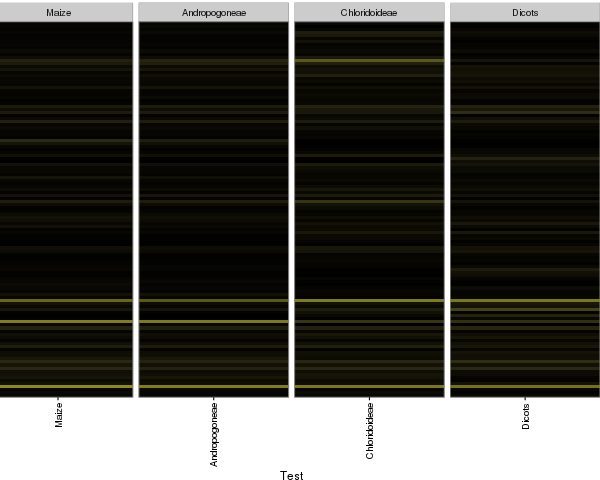

In [230]:
%%R -w 600

# function for making responder plot
responders_plot = function(metadata, plot.margin=NULL){
    if(is.null(plot.margin)){
        plot.margin = unit(c(0.1,0,-.1,-0.7), "cm")  # top, right, bottom, left        
    }
    
    metadata.ord = metadata %>%
        mutate(responder = padj < 0.05,
               responder.num = responder %>% as.numeric)
    
    metadata.ord$Fill = ifelse(metadata.ord$padj < 0.05 & metadata.ord$direction == "Pos", "A", 
                               ifelse(metadata.ord$padj < 0.05 & metadata.ord$direction == "Neg", "C", "B"))
    
   # metadata.ord$Day = reorder(metadata.ord$Day, metadata.ord$Day %>% as.numeric)

    min.y = metadata.ord$y.tree %>% min(na.rm=T)
    max.y = metadata.ord$y.tree %>% max(na.rm=T)    
    
    PosResponders = filter(metadata.ord, padj <0.05 & log2FoldChange > 0)
    NonResp = filter(metadata.ord, padj >0.05 | log2FoldChange <0 & padj < 0.05)
    Filtered = filter(metadata.ord, is.na(padj))
    
p.responder = ggplot() + 
 #   geom_tile(data = NonResp, aes(x = Test, y.tree, alpha=0), fill = "black") +
 #   scale_y_continuous(expand=c(0,0)) +

    geom_tile(data = metadata.ord, aes(x = Test, y.tree, fill = RelAbund)) +
    scale_fill_gradient( low = "Black", high = "Yellow", limit = c(.000, .063)) +
    #scale_fill_gradient(low = "Black", high = "Yellow") +
    scale_y_continuous(expand=c(0,0)) +
    
#     p.responder = ggplot() +
#         geom_tile(data = metadata.ord, aes(x = Test, y = y.tree, fill = Fill, alpha=responder.num)) +
#         scale_fill_manual(values=c('green', 'blue', 'red')) +
#         scale_y_continuous(expand=c(0,0)) +
        facet_grid(. ~ Test, scales='free_x') +
        theme_bw() +
        theme(
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            axis.text.x = element_text(angle=90, vjust=0.5, hjust=1),
            axis.title.y = element_blank(),
            axis.text.y = element_blank(),
            axis.ticks.y = element_blank(),
            legend.position = 'none',
            plot.margin = plot.margin    
            )   
    return(p.responder)
    }

# #-- test --#
p.responders = responders_plot(l2fc.ord)
p.responders

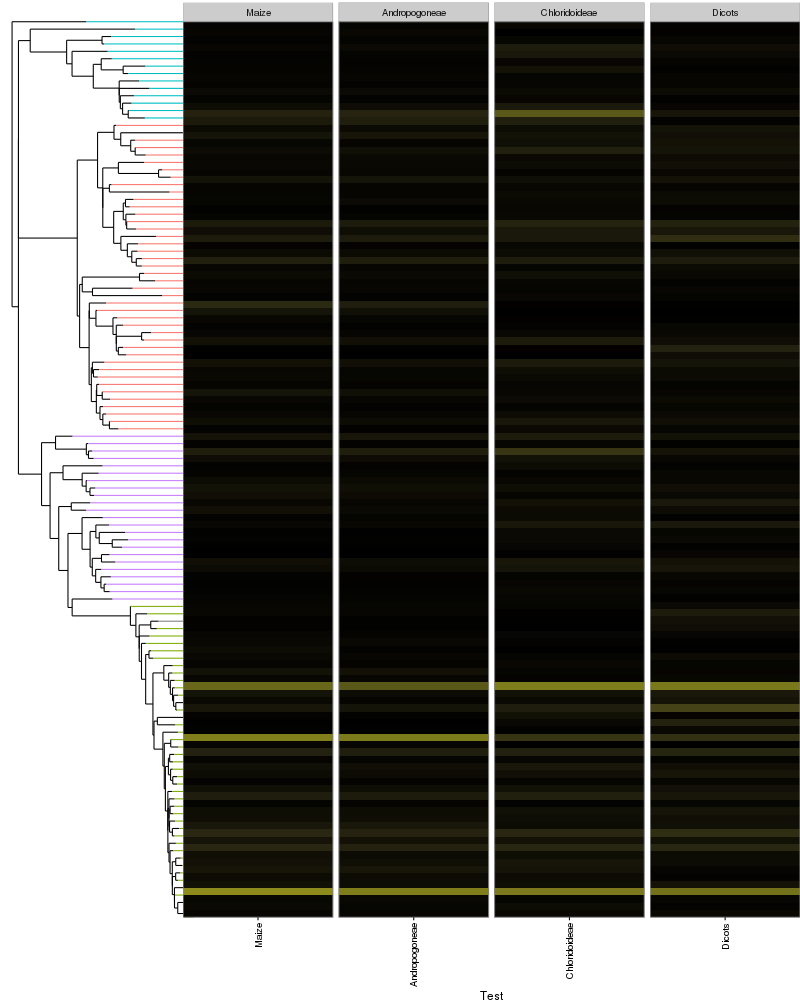

In [232]:
%%R -w 800 -h 1000
resize_ggplots = function(ggplot.list,
                          resize.index = length(ggplot.list),
                          widths=rep(1, length(ggplot.list))){
    # other.plots = list of plots
    stopifnot(class(ggplot.list)[1] == 'list')
    
    ## making gtables
    make_gt = function(x) ggplot_gtable(ggplot_build(x))
    gt = lapply(ggplot.list, make_gt)
        
    # resizing
    gt.len = length(gt)    
    for(i in 1:gt.len){
        if(i == resize.index){
            next
        } else {
            gt[[i]]$heights = gt[[resize.index]]$heights
        }
    }
        
    # grid.arrange params
    params.l = list('ncol' = gt.len, 'widths' = widths)

    # return list of gtables + params
    return(c(gt, params.l))
    } 

x = resize_ggplots(list(p.tree, p.responders), 
                   widths=c(.6,1.8))
do.call(grid.arrange, x)

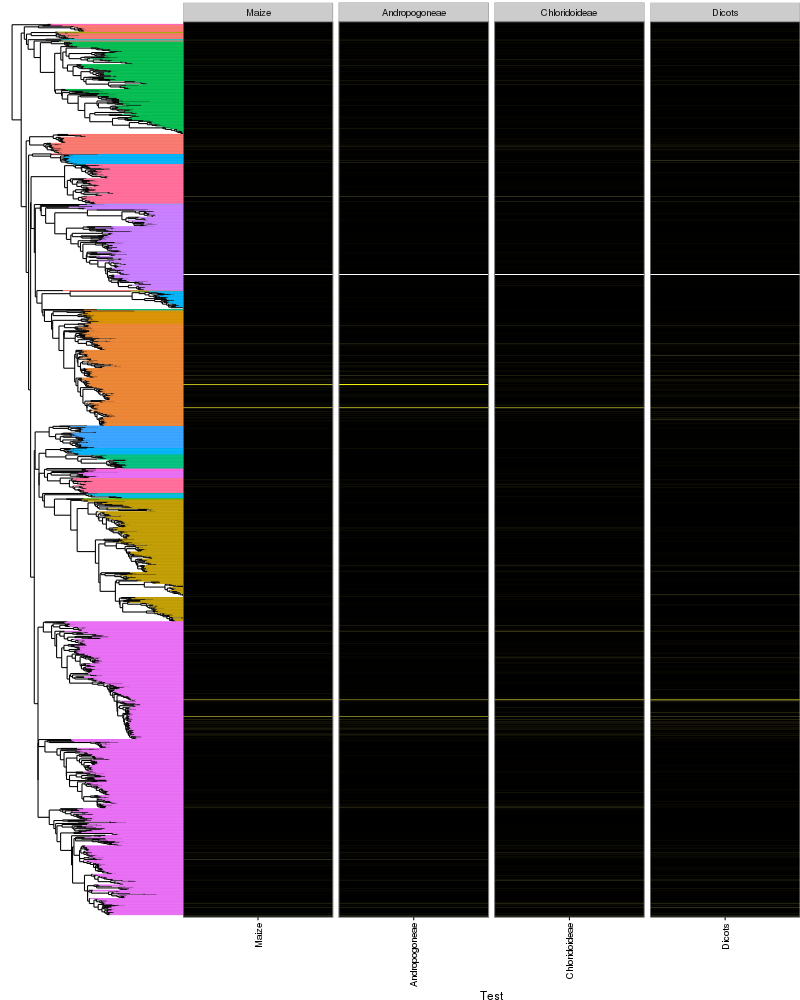

In [233]:
%%R -w 800 -h 1000
# tree plot
p.tree = plot_tree(phy, 
                   legend.title=' Phylum', 
                   y.expand=c(0.003,0.003),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))

# order metadata
l2fc.s = l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## taxa by tree
l2fc.ord = order_metadata_to_tree(phy, l2fc.s) 

# plotting metadata
## plot.margin: top, right, bottom, left 
p.responders = responders_plot(l2fc.ord)



# plotting
gt = resize_ggplots(list(p.tree, p.responders),
                    widths=c(.6,1.8))
do.call(grid.arrange, gt)

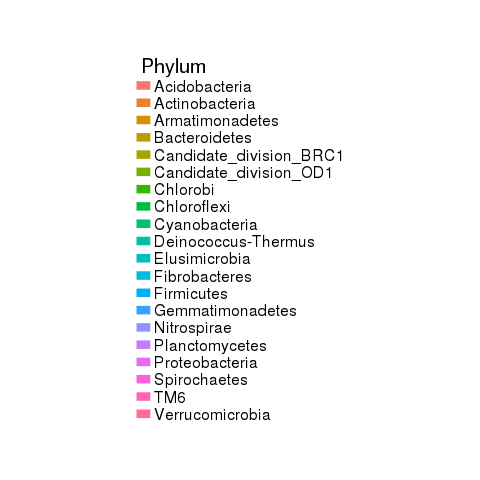

In [234]:
%%R
# tree legend
my.legend = g_legend(p.tree)
grid.draw(my.legend)

## full tree; just phylogeny responders filter low abundance OTUs for clarity

In [235]:
%%R
head(l2fc)

    baseMean log2FoldChange     lfcSE          stat       pvalue        padj
1  0.1669131   0.9341849010 0.6861643  1.3614594753 0.1733685318 0.297044581
2  0.6311662   1.3533367388 0.3723908  3.6341838849 0.0002788619 0.001833913
3  1.9873323  -0.2593614348 0.2706771 -0.9581949320 0.3379644723 0.479712060
4  0.5950191   0.0002442723 0.3377740  0.0007231827 0.9994229837 0.999422984
5  0.8520297   0.0566378903 0.3149033  0.1798580480 0.8572640109 0.915630922
6 28.6100613  -0.3534431194 0.1025579 -3.4462775828 0.0005683662 0.003330582
     Rank1         Rank2                Rank3                Rank4 Rank5 Rank6
1 Bacteria           TM6 uncultured_bacterium                 <NA>  <NA>  <NA>
2 Bacteria           TM6 uncultured_bacterium                 <NA>  <NA>  <NA>
3 Bacteria Elusimicrobia          Lineage_IIb uncultured_bacterium  <NA>  <NA>
4 Bacteria Elusimicrobia          Lineage_IIb uncultured_bacterium  <NA>  <NA>
5 Bacteria Elusimicrobia               MVP-88 uncultured_bacterium

In [236]:
%%R
# Identify responders in any treatment category 

padj.cutoff = 0.05

l2fc.s = l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8) %>%
    group_by(OTU) %>%
    summarize(Responder = any(padj < padj.cutoff) %>% as.numeric) %>%
    ungroup() 
tax = phy %>% tax_table %>% as.data.frame
tax$OTU = rownames(tax)
tax.j = left_join(tax, l2fc.s, c('OTU' = 'OTU')) %>% 
    mutate(Responder = ifelse(is.na(Responder), 0, Responder)) %>%
    as.data.frame() 
rownames(tax.j) = tax.j$OTU %>% as.character
tax.j$OTU = NULL

# making new phyloseq object with incorporator info
phy.resp = phyloseq(phy %>% otu_table, 
                             tax.j %>% as.matrix %>% tax_table, 
                             phy %>% sample_data,
                             phy %>% phy_tree)
physeq.resp = subset_taxa(phy.resp, Responder==1)
physeq.resp = prune_taxa(taxa_sums(physeq.resp) > 0.1, physeq.resp)
physeq.resp

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 912 taxa and 174 samples ]
sample_data() Sample Data:       [ 174 samples by 56 sample variables ]
tax_table()   Taxonomy Table:    [ 912 taxa by 9 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 912 tips and 911 internal nodes ]


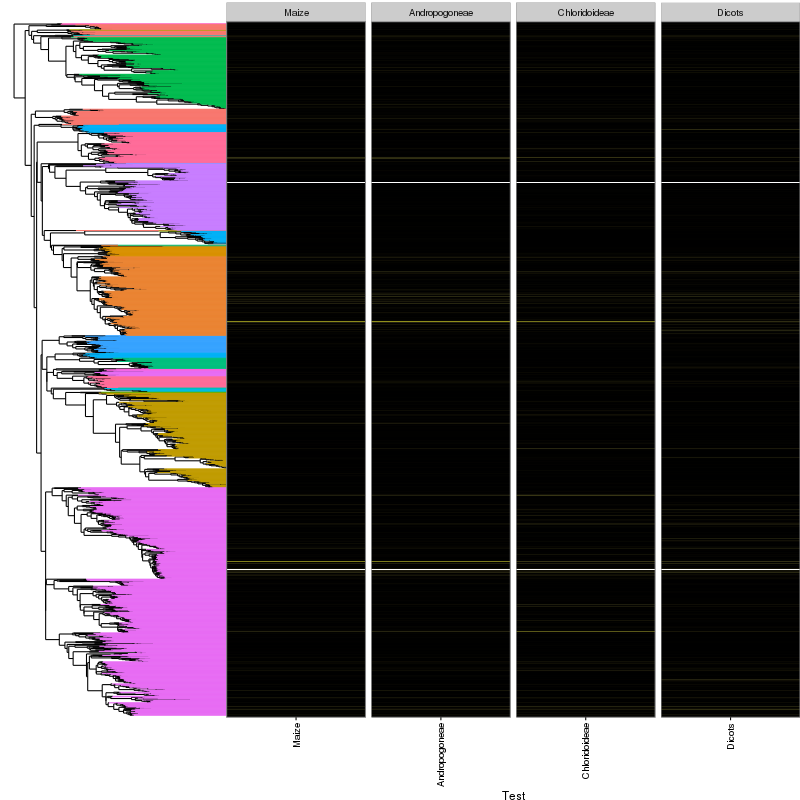

In [237]:
%%R -w 800 -h 800

p.tree = plot_tree(phy.resp, 
                   legend.title=' Phylum', 
                   y.expand=c(0.003,0.003),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))

# order metadata
l2fc.s = l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## taxa by tree
l2fc.ord = order_metadata_to_tree(phy.resp, l2fc.s) 


# plotting metadata
## plot.margin: top, right, bottom, left 
p.responders = responders_plot(l2fc.ord)

# plotting
gt = resize_ggplots(list(p.tree, p.responders),
                    widths=c(0.7,1.6))
do.call(grid.arrange, gt)

## full tree; just high abundance OTUs  for clarity

In [238]:
%%R
head(l2fc)

    baseMean log2FoldChange     lfcSE          stat       pvalue        padj
1  0.1669131   0.9341849010 0.6861643  1.3614594753 0.1733685318 0.297044581
2  0.6311662   1.3533367388 0.3723908  3.6341838849 0.0002788619 0.001833913
3  1.9873323  -0.2593614348 0.2706771 -0.9581949320 0.3379644723 0.479712060
4  0.5950191   0.0002442723 0.3377740  0.0007231827 0.9994229837 0.999422984
5  0.8520297   0.0566378903 0.3149033  0.1798580480 0.8572640109 0.915630922
6 28.6100613  -0.3534431194 0.1025579 -3.4462775828 0.0005683662 0.003330582
     Rank1         Rank2                Rank3                Rank4 Rank5 Rank6
1 Bacteria           TM6 uncultured_bacterium                 <NA>  <NA>  <NA>
2 Bacteria           TM6 uncultured_bacterium                 <NA>  <NA>  <NA>
3 Bacteria Elusimicrobia          Lineage_IIb uncultured_bacterium  <NA>  <NA>
4 Bacteria Elusimicrobia          Lineage_IIb uncultured_bacterium  <NA>  <NA>
5 Bacteria Elusimicrobia               MVP-88 uncultured_bacterium

[1] 1506
[1] 282   3
# A tibble: 6 x 3
        OTU         Max Responder
     <fctr>       <dbl>     <dbl>
1    OTU.10 0.036565506         1
2   OTU.100 0.005263027         1
3   OTU.101 0.003369402         0
4   OTU.102 0.002973672         1
5 OTU.10249 0.003626410         1
6 OTU.10253 0.001739108         1


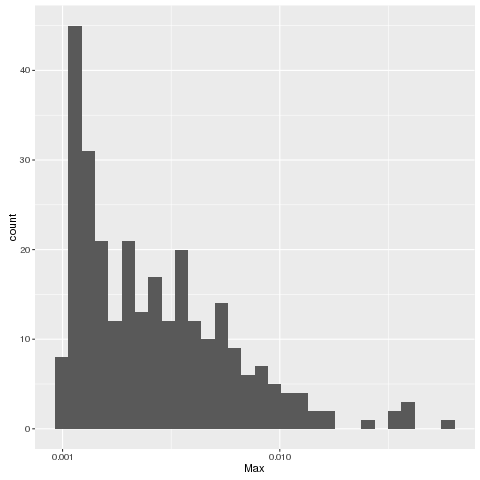

In [239]:
%%R
l2fc$OTU %>% unique %>% length %>% print 

Resp = l2fc %>% 
    group_by(OTU) %>%
    summarize(Max = max(RelAbund),
               Responder = any(padj < 0.05) %>% as.numeric) %>% 
    filter(Max > 0.001)
 p =   ggplot(Resp, aes(x = Max)) + 
        geom_histogram() + 
        scale_x_log10() 


dim(Resp) %>% print
head(Resp) %>% print
p

In [240]:
%%R
l2fc %>% 
    filter(OTU %in% TL) %>%
    arrange(-RelAbund) %>% head

  baseMean log2FoldChange     lfcSE        stat       pvalue         padj
1 182.7151     4.77938846 0.2621933 18.22849197 3.066610e-74 4.618314e-71
2 279.2668     4.00265021 0.1958049 20.44203761 7.072395e-93 3.550342e-90
3 292.9545     0.47760052 0.2847738  1.67712243 9.351854e-02 1.794126e-01
4 318.0228     0.40471770 0.2213519  1.82839025 6.749100e-02 1.789462e-01
5 403.7892     0.01044191 0.1397793  0.07470285 9.404511e-01 9.602166e-01
6 366.2133     0.77094079 0.1948427  3.95673515 7.598109e-05 6.119119e-04
     Rank1          Rank2              Rank3              Rank4          Rank5
1 Bacteria Actinobacteria   Streptomycetales  Streptomycetaceae   Streptomyces
2 Bacteria Actinobacteria   Streptomycetales  Streptomycetaceae   Streptomyces
3 Bacteria Actinobacteria  Pseudonocardiales Pseudonocardiaceae           <NA>
4 Bacteria Actinobacteria   Streptomycetales  Streptomycetaceae   Streptomyces
5 Bacteria Proteobacteria Betaproteobacteria    Burkholderiales Comamonadaceae
6 Bacter

In [241]:
%%R
TL = Resp$OTU %>% unique %>% as.character
l2f = NULL

phy.p = prune_taxa(TL, phy)
phy.p

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 282 taxa and 174 samples ]
sample_data() Sample Data:       [ 174 samples by 56 sample variables ]
tax_table()   Taxonomy Table:    [ 282 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 282 tips and 281 internal nodes ]


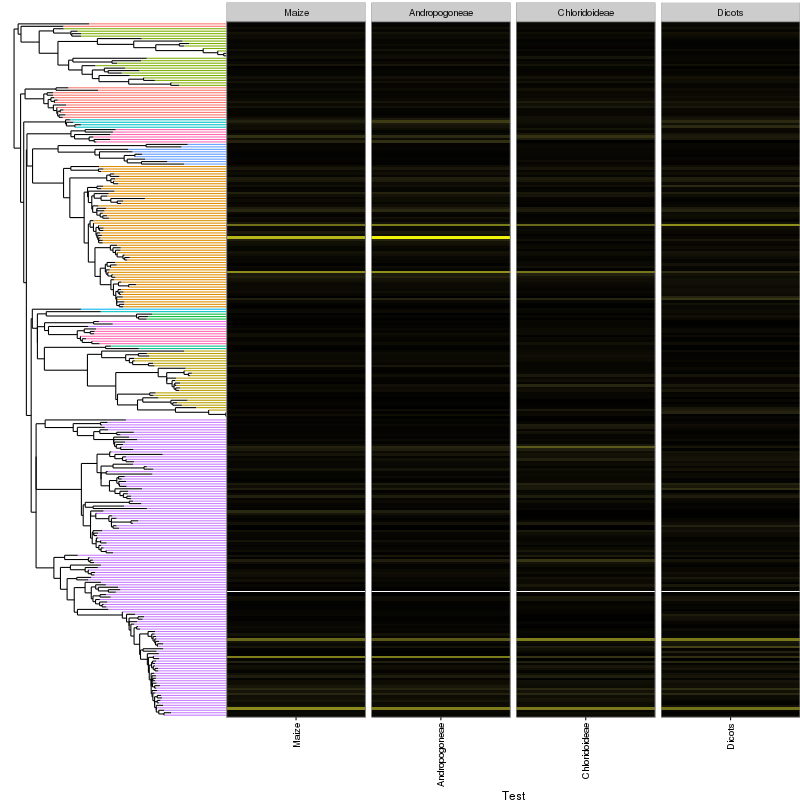

In [281]:
%%R -w 800 -h 800

p.tree = plot_tree(phy.p, 
                   legend.title=' Phylum', 
                   y.expand=c(0.003,0.003),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))

# order metadata
l2fc.s = l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## taxa by tree
l2fc.ord = order_metadata_to_tree(phy.p, l2fc.s) 


# plotting metadata
## plot.margin: top, right, bottom, left 
p.responders = responders_plot(l2fc.ord)



# plotting
gt = resize_ggplots(list(p.tree, p.responders),
                    widths=c(0.7,1.6))
do.call(grid.arrange, gt)

In [280]:
%%R
# plot l2fc sig results 
Resp = l2fc %>% 
    filter(padj < 0.05 & direction == "Pos") %>%
    .$OTU %>%
    unique %>%
    as.character()
l2fc.ord.resp = filter(l2fc.ord, OTU %in% Resp)
p.l2f = ggplot(l2fc.ord.resp, aes(x = 1, y = y.tree), color = "Orange") +
        geom_point()
length(Resp)

[1] 511


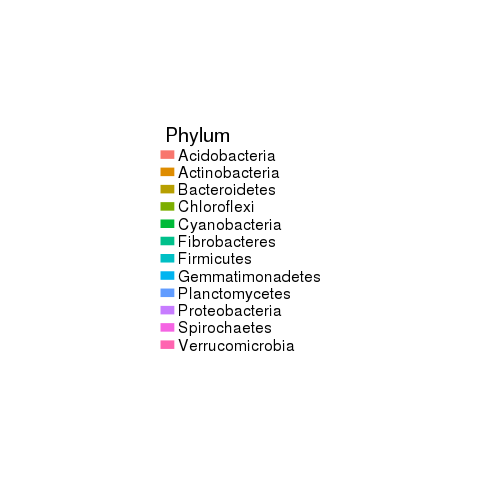

In [251]:
%%R
# tree legend
my.legend = g_legend(p.tree)
grid.draw(my.legend)

# Just actinobacteria

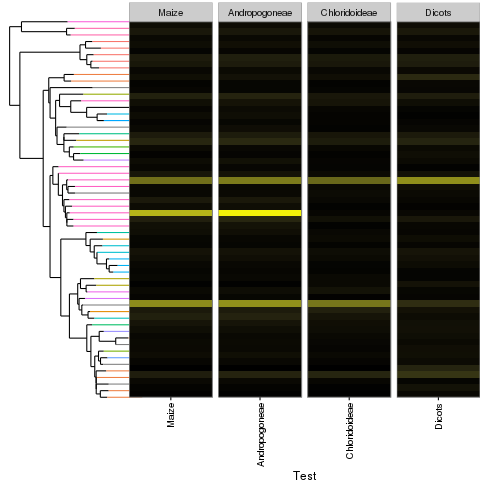

In [244]:
%%R
# phylum selection
phylum = "Actinobacteria"
physeq_1phy = subset_taxa(phy.p, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank5',
                   legend.title='Family',
                   y.expand=c(0,0),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))
                   #y.expand=c(-0.002,-0.002),
                   #plot.margin=unit(c(0,-0.1,0,0), 'cm'))

# order metadata
l2fc.s = l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)

## taxa by tree using all rhizosphere responders
l2fc.ord = order_metadata_to_tree(physeq_1phy, l2fc.s) 


# plotting metadata
## plot.margin: top, right, bottom, left 
p.responders = responders_plot(l2fc.ord)



# plotting
gt = resize_ggplots(list(p.tree, p.responders),
                    widths=c(0.7,1.6))
do.call(grid.arrange, gt)


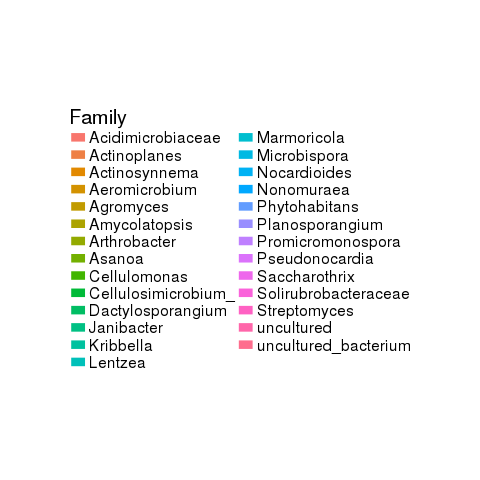

In [245]:
%%R
# tree legend
my.legend = g_legend(p.tree)
grid.draw(my.legend)

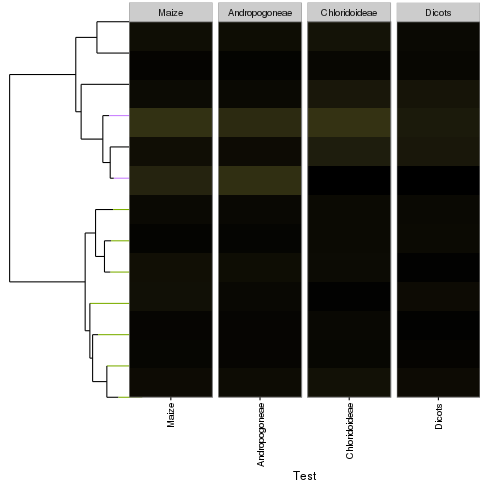

In [246]:
%%R
# phylum selection
phylum = "Verrucomicrobia"
physeq_1phy = subset_taxa(phy.p, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank3',
                   legend.title='Class',
                   y.expand=c(0,0),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))
                   #y.expand=c(-0.002,-0.002),
                   #plot.margin=unit(c(0,-0.1,0,0), 'cm'))

# order metadata
l2fc.s = l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)

## taxa by tree using all rhizosphere responders
l2fc.ord = order_metadata_to_tree(physeq_1phy, l2fc.s) 


# plotting metadata
## plot.margin: top, right, bottom, left 
p.responders = responders_plot(l2fc.ord)

# plotting
gt = resize_ggplots(list(p.tree, p.responders),
                    widths=c(0.7,1.6))
do.call(grid.arrange, gt)

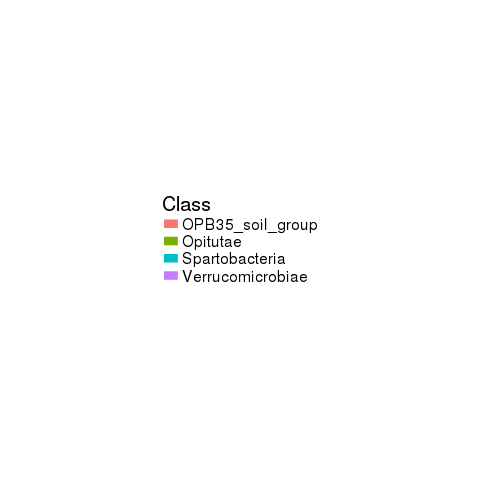

In [247]:
%%R
# tree legend
my.legend = g_legend(p.tree)
grid.draw(my.legend)

# Proteobacteria

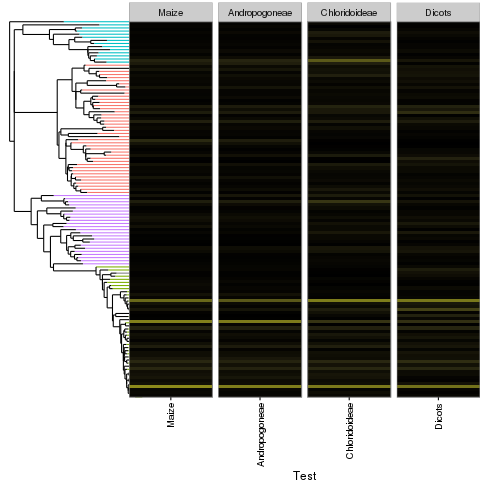

In [248]:
%%R
# phylum selection
phylum = "Proteobacteria"
physeq_1phy = subset_taxa(phy.p, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank3',
                   legend.title='Order',
                   y.expand=c(0,0),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))
                   #y.expand=c(-0.002,-0.002),
                   #plot.margin=unit(c(0,-0.1,0,0), 'cm'))

# order metadata
l2fc.s = l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)

## taxa by tree using all rhizosphere responders
l2fc.ord = order_metadata_to_tree(physeq_1phy, l2fc.s) 


# plotting metadata
## plot.margin: top, right, bottom, left 
p.responders = responders_plot(l2fc.ord)


# plotting
gt = resize_ggplots(list(p.tree, p.responders),
                    widths=c(0.7,1.6))
do.call(grid.arrange, gt)

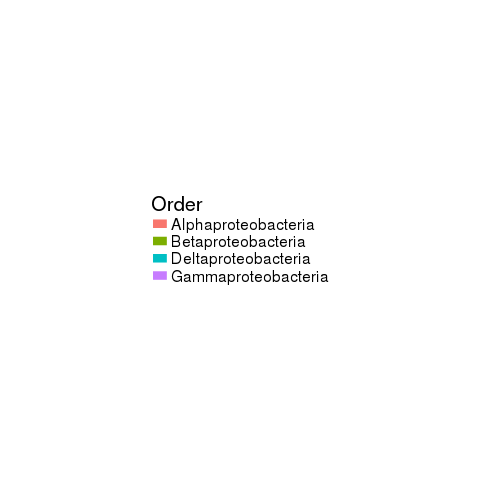

In [249]:
%%R
# tree legend
my.legend = g_legend(p.tree)
grid.draw(my.legend)

In [256]:
%%R
figDir = "/home/bryan/RhizCG/figures/"

In [257]:
%%R
# saving figure
outFile = 'PlantPhy_Responders_Abundant.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=800 / 65, height=800 / 65)
do.call(grid.arrange, gt)
dev.off()

png 
  2 


In [259]:
%%R
# saving legend
outFile = 'PlantPhy_Responders_Abundant_leg.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=500 / 65, height=500 / 65)
my.legend = g_legend(p.tree)
grid.draw(my.legend)
dev.off()

png 
  2 
